#  Cell Type Entropies and Joint Mutual Informations

This notebook evaluates estimation of the joint mutual information (using KSG in Kraskov, et al,2004, and revised KSG in Gao, et al, 2018), and kullback leibler divergence (using Wang, et al, 2009) between bipolar subtypes from mouse Retina. We also invetigate how differential entropy (using Kozachenko and Leonenko 1987) and NNRI ( (Nearest Neighbour Regularity Index defined in Keeley, et al 2019) behaves for individual cell types. 


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import pandas as pd
from scipy.special import psi, digamma, gamma
import scipy.spatial as ss
from math import log,pi,exp


In [2]:


def coord_transfer(xcoords, ycoords):
    '''
    computes appropriate [center_shift_x , center_shift_y] valuse so that the origin is 
    shifted to the mean of all coordinates and rotatation theta theta_shift so that 
    theta values are continuous between 0 and 2*pi.
    Input:
    
         xcoords   : array_like Input data X Cartesian Coordinates. 
         ycoords   : array_like Input data Y Cartesian Coordinates. 

    Output:
    
         [center_shift_x , center_shift_y]: The values of the proper coordinate shifts 
                                            so that origin is located in the center of the mass.

         theta_shift  : The value of required rotation so the theta values are continuous.   
    '''
    center_shift_x=np.mean(xcoords)
    center_shift_y=np.mean(ycoords)

    xcoords=xcoords-center_shift_x
    ycoords=ycoords-center_shift_y

    xcoordspi=xcoords>0
    xcoordsni=xcoords<0

    posi=np.argmax(xcoords[xcoordspi]**2+ycoords[xcoordspi]**2)
    negi=np.argmax(xcoords[xcoordsni]**2+ycoords[xcoordsni]**2)


    ymax=ycoords[xcoordspi][posi]
    ymin=ycoords[xcoordsni][negi]
    xmax=xcoords[xcoordspi][posi]
    xmin=xcoords[xcoordsni][negi]

    slope=(ymax-ymin)/(xmax-xmin)
    theta=np.arctan(slope)

    #rotatet the frame so that  first theta does not start from zero, and hence becomes continous
    theta_shift=theta-np.pi/2  
    return [center_shift_x , center_shift_y], theta_shift



def kraskov_mi(x,y,k=5):
    '''
        Estimate the mutual information I(X;Y) of X and Y from samples {x_i, y_i}_{i=1}^N
        Using KSG mutual information estimator

        Input: x: 2D list of size N*d_x
        y: 2D list of size N*d_y
        k: k-nearest neighbor parameter

        Output: one number of I(X;Y)
    '''

    assert len(x)==len(y), "Lists should have same length"
    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    N = len(x)
    dx = np.size(x)//len(x)      
    dy = np.size(y)//len(y)
    data = np.concatenate((x,y),axis=1)

    tree_xy = ss.cKDTree(data)
    tree_x = ss.cKDTree(x)
    tree_y = ss.cKDTree(y)

    knn_dis = [tree_xy.query(point,k+1,p=float('inf'))[0][k] for point in data]
    ans_xy = -digamma(k) + digamma(N) + (dx+dy)*log(2)#2*log(N-1) - digamma(N) #+ vd(dx) + vd(dy) - vd(dx+dy)
    ans_x = digamma(N) + dx*log(2)
    ans_y = digamma(N) + dy*log(2)
    ndx=[]
    ndy=[]
    for i in range(N):


        ans_x += -digamma(len(tree_x.query_ball_point(x[i],knn_dis[i]-1e-15,p=float('inf'))))/N
        ndx=np.append(ndx,len(tree_x.query_ball_point(x[i],knn_dis[i]-1e-15,p=float('inf'))) )
        ans_y += -digamma(len(tree_y.query_ball_point(y[i],knn_dis[i]-1e-15,p=float('inf'))))/N
        ndy=np.append(ndy,len(tree_y.query_ball_point(y[i],knn_dis[i]-1e-15,p=float('inf'))) )


    return ans_x+ans_y-ans_xy
def revised_mi(x,y,k=5,q=float('inf')):
    '''
        Estimate the mutual information I(X;Y) of X and Y from samples {x_i, y_i}_{i=1}^N
        Using *REVISED* KSG mutual information estimator (see arxiv.org/abs/1604.03006)
        Input: x: 2D list of size N*d_x
        y: 2D list of size N*d_y
        k: k-nearest neighbor parameter
        q: l_q norm used to decide k-nearest distance
        Output: one number of I(X;Y)
    '''

    assert len(x)==len(y), "Lists should have same length"
    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    N = len(x)
    dx = len(x[0])       
    dy = len(y[0])
    data = np.concatenate((x,y),axis=1)

    tree_xy = ss.cKDTree(data)
    tree_x = ss.cKDTree(x)
    tree_y = ss.cKDTree(y)

    knn_dis = [tree_xy.query(point,k+1,p=q)[0][k] for point in data]
    ans_xy = -digamma(k) + log(N) + vd(dx+dy,q)
    ans_x = log(N) + vd(dx,q)
    ans_y = log(N) + vd(dy,q)
    for i in range(N):
        ans_xy += (dx+dy)*log(knn_dis[i])/N
        ans_x += -log(len(tree_x.query_ball_point(x[i],knn_dis[i]+1e-15,p=q))-1)/N+dx*log(knn_dis[i])/N
        ans_y += -log(len(tree_y.query_ball_point(y[i],knn_dis[i]+1e-15,p=q))-1)/N+dy*log(knn_dis[i])/N        
    return ans_x+ans_y-ans_xy
def vd(d,q):
    # Compute the volume of unit l_q ball in d dimensional space
    if (q==float('inf')):
        return d*log(2)
    return d*log(2*gamma(1+1.0/q)) - log(gamma(1+d*1.0/q))


def xy_mi(cpos1, cpos2, cpos3, ki=5, mi_mode='rksg'):
    '''  
    Uses cartezian positions of the cell types to estimate joint mutual information
    Input:
    
         cpos1, cpos2, cpos3   : array_like N by d (N=number of samples, d= dimension) Input data Cartesian Coordinates. 
         ki: Number of knn for ksg and revised ksg
         mi_mode: either 'ksg' for original ksg algorithm, and 'rksg' for the revised one

    Output:
    
        I2g, I3g, I23g= mutual information between celltype2, celltype2, (celltype2, celltype3) and celltype1
    '''
    dz12=distance_matrix(cpos1, cpos2)
    paired_index_12=np.argsort(dz12, axis=1)[:,0]
    cpos2_paired=cpos2[paired_index_12]

    dz13=distance_matrix(cpos1, cpos3)
    paired_index_13=np.argsort(dz13, axis=1)[:,0]
    cpos3_paired=cpos3[paired_index_13]
    cpos23_paired=np.vstack(( cpos3_paired.T,cpos2_paired.T)).T
    if (mi_mode=='ksg'):
        I2g=kraskov_mi(cpos2_paired, cpos1, k=ki)
        I3g=kraskov_mi(cpos3_paired, cpos1, k=ki)
        I23g=kraskov_mi(cpos23_paired, cpos1, k=ki )
    else:
        I2g=revised_mi(cpos2_paired, cpos1, k=ki, q=2)
        I3g=revised_mi(cpos3_paired, cpos1, k=ki, q=2)
        I23g=revised_mi(cpos23_paired, cpos1,k=ki,q=2) 

    return  I2g, I3g, I23g

def xyd_mi(cpos1, cpos2, cpos3, ki=5, mi_mode='rksg'):
    '''  
    Uses minimum distances between the cell types to estimate joint mutual information
    Input:
    
         cpos1, cpos2, cpos3   : array_like N by d (N=number of samples, d= dimension) Input data Cartesian Coordinates. 
         ki: Number of knn for ksg and revised ksg
         mi_mode: either 'ksg' for original ksg algorithm, and 'rksg' for the revised one

    Output:
    
        I2g, I3g, I23g= mutual information between celltype2, celltype2, (celltype2, celltype3) and celltype1 minimum distances
    '''
    dz11=distance_matrix(cpos1, cpos1)
    dz11_min=np.sort(dz11, axis=1)[:,1]


    dz12=distance_matrix(cpos1, cpos2)
    dz12_min=np.sort(dz12, axis=1)[:,0]


    dz13=distance_matrix(cpos1, cpos3)
    dz13_min=np.sort(dz13, axis=1)[:,0]


    dz123_paired=np.vstack(( dz12_min.T,dz13_min.T)).T

    if (mi_mode=='ksg'):
 
        I2g=kraskov_mi(dz12_min[:,None], dz11_min[:,None], k=ki)
        I3g=kraskov_mi(dz12_min[:,None], dz11_min[:,None], k=ki)
        I23g=kraskov_mi(dz123_paired, dz11_min[:,None], k=ki)
    else: 
 
        I2g=revised_mi(dz12_min[:,None], dz11_min[:,None],  k=ki,q=2)
        I3g=revised_mi(dz12_min[:,None], dz11_min[:,None],  k=ki,q=2)
        I23g=revised_mi(dz123_paired, dz11_min[:,None],  k=ki, q=2) 

    return  I2g, I3g, I23g    

def entropy(x,k=5,q=float('inf')):
    '''  
    Estimator of (differential entropy) of X Using k-nearest neighbor methods 
    Input:
    
         x   : array_like N by d (N=number of samples, d= dimension) Input data Cartesian Coordinates. 
         k: Number of knn for kl entropy estimator
         q: q-norm distance used for knn

    Output:
    
        he= estimated differential entropy
    '''
    

    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    N = len(x)
    d = np.size(x)//N 
    tree = ss.cKDTree(x)
    knn_dis = [tree.query(point,k+1,p=q)[0][k] for point in x]
    ans = -digamma(k) + digamma(N) + vd(d,q)
    he=ans + d*np.mean(list(map(log,knn_dis)))
    return he


def test_ksg_gao(n_samples=5000):
    '''  
    Compares performance of the KSG and revised KSG with the real mutual informations
    Input:
    
         n_samples   : Number of samples to be used for estimating mutual information

    '''
    # joint normal distribution is computed at these points 
    xv=np.linspace(-10, 10, 100)
    yv=np.linspace(-10, 10, 100)
    zv=np.linspace(-10, 10, 100)



    Ixy_zgaov=[]
    Ixy_gaov=[]
    Ixy_zksgv=[]
    Ixy_ksgv=[]
    Ixy_zv=[]
    Ixyv=[]
    pxyz=np.zeros([100, 100, 100])
    rv=np.linspace(0, 1, 9)
    for r in rv:
        # parameterized positive definite covarianc matrix
        cov=np.array([[1, r, 0.97-r], [r, 1, r], [0.97-r, r,1]])
        cov=cov@cov.T
        # setting a lower boung for the eigen values, to make sure the covariance matrix is not ill behaved
        u, s, v=np.linalg.svd(cov)
        s[s<0.01]=0.01


        covi=np.linalg.inv(cov)
        xi=0
        yi=0
        zi=0
        for x in xv:
            for y in yv:
                for z in zv:
                    xyz=np.array([x, y, z])[:, None]

                    pxyz[xi, yi, zi]=np.exp(-1/2*xyz.T@covi@xyz)
                    zi+=1
                yi+=1
                zi=0
            xi+=1
            yi=0
            zi=0
        #normalizing to 1
        pxyz=pxyz/np.sum(pxyz)
        pxy=np.sum(pxyz, axis=2)
        px=np.sum(pxy, axis=1)
        py=np.sum(pxy, axis=0)
        pz=np.sum(np.sum(pxyz, axis=0), axis=0)
        #I(x; y)
        tmp=pxy*np.log(pxy/np.outer(px, py))
        tmp=tmp[~np.isnan(tmp)]
        tmp=tmp[tmp<np.inf]
        Ixy=np.sum(tmp)
        Ixyv=np.append(Ixyv, Ixy)
        
        #I(x, y;z)
        
        tmp=pxyz*np.log(pxyz/(pxy[:, :,None]@pz[None, :]))
        tmp=tmp[~np.isnan(tmp)]
        tmp=tmp[tmp<np.inf]
        Ixy_z=np.sum(tmp)
        Ixy_zv=np.append(Ixy_zv, Ixy_z)
        
        # Using KSG and revised KSG to estimate mutual information

        xyzr=np.random.multivariate_normal([0,0,0], cov, n_samples)
        xr=xyzr[:,0][:,None]
        yr=xyzr[:,1][:,None]
        xyr=xyzr[:, :2]
        zr=xyzr[:,2][:,None]


        
        Ixy_ksg=kraskov_mi(xr, yr)
        Ixy_ksgv=np.append(Ixy_ksgv, Ixy_ksg)

        Ixy_gao=revised_mi(xr, yr, q=2)
        Ixy_gaov=np.append(Ixy_gaov, Ixy_gao)

        Ixy_zksg=kraskov_mi(xyr, zr)
        Ixy_zksgv=np.append(Ixy_zksgv, Ixy_zksg)

        Ixy_zgao=revised_mi(xyr, zr, q=2)
        Ixy_zgaov=np.append(Ixy_zgaov, Ixy_zgao)

    fig, axs=plt.subplots(2)
    fig.suptitle('Comparison Between KSG and RGAO')
    axs[0].plot(rv, Ixyv)
    axs[0].plot(rv, Ixy_ksgv)
    axs[0].plot(rv, Ixy_gaov)
    axs[0].legend(['xy Theory', 'xy KSG', 'xy RGao'])
    axs[0].set_ylabel('I(x:y)')

    axs[1].plot(rv, Ixy_zv)
    axs[1].plot(rv, Ixy_zksgv)
    axs[1].plot(rv, Ixy_zgaov)
    axs[1].legend(['xy_z Theory', 'xy_z KSG', 'xy_z RGao'])
    axs[1].set_xlabel('correlation parameter')
    axs[1].set_ylabel('I(x, y:z)')
    return 1




Testing KSG and revised KSG proposed by Gao(2018) prformance to estimate mutual information of the Gaussian data generated with a parameterized covariance matrix. 

I had used $1000$ samples to estimate mutual information with KSG and revised KSG in the slides I presented. Upon using $5000$ samples, the difference between real MI and estimated MI disappears. 

D:\TEMP1/ipykernel_11644/2021529400.py:282: RuntimeWarning: divide by zero encountered in log
  tmp=pxyz*np.log(pxyz/(pxy[:, :,None]@pz[None, :]))
D:\TEMP1/ipykernel_11644/2021529400.py:282: RuntimeWarning: invalid value encountered in multiply
  tmp=pxyz*np.log(pxyz/(pxy[:, :,None]@pz[None, :]))
D:\TEMP1/ipykernel_11644/2021529400.py:274: RuntimeWarning: divide by zero encountered in log
  tmp=pxy*np.log(pxy/np.outer(px, py))
D:\TEMP1/ipykernel_11644/2021529400.py:274: RuntimeWarning: invalid value encountered in multiply
  tmp=pxy*np.log(pxy/np.outer(px, py))
D:\TEMP1/ipykernel_11644/2021529400.py:282: RuntimeWarning: divide by zero encountered in true_divide
  tmp=pxyz*np.log(pxyz/(pxy[:, :,None]@pz[None, :]))
D:\TEMP1/ipykernel_11644/2021529400.py:282: RuntimeWarning: invalid value encountered in true_divide
  tmp=pxyz*np.log(pxyz/(pxy[:, :,None]@pz[None, :]))


1

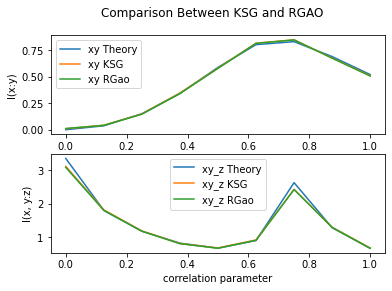

In [3]:

test_ksg_gao(5000)




## Reading and translation of cell locations.

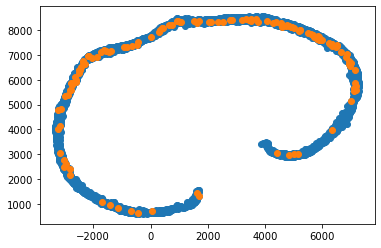

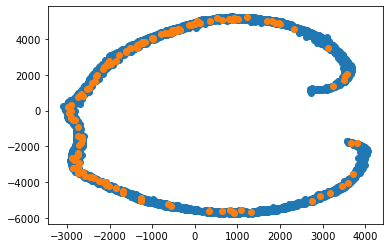

In [4]:
xy_table=pd.read_csv('data/Retina1.csv')


xcoords=[]
ycoords=[]
xy_Subtype=[]

xy_r11=xy_table[(xy_table.SectionNumber==1)]
xcoords=xy_r11.Remapped_X.values
ycoords=xy_r11.Remapped_Y.values
xy_Subtype= np.array(xy_r11.Subtype)

xy_Subtype_Shuffle=xy_Subtype.copy()
np.random.shuffle(xy_Subtype_Shuffle)
plt.figure()
plt.scatter(xcoords, ycoords)
plt.scatter(xcoords[xy_Subtype==1], ycoords[xy_Subtype==1])


# Computing appropriate shift and rotate values and applying them on the input coordinates. 



center_shift, theta_shift=coord_transfer(xcoords, ycoords)
center_shift_x=center_shift[0]
center_shift_y=center_shift[1]
xcoords=xcoords-center_shift_x
ycoords=ycoords-center_shift_y
xcoords_rot=(np.cos(theta_shift)*xcoords+np.sin(theta_shift)*ycoords)
ycoords_rot=(np.cos(theta_shift)*ycoords-np.sin(theta_shift)*xcoords)
zcoords=np.vstack((xcoords_rot, ycoords_rot)).T


# Computing polar coordinates of the input data, and sorting them based on their theta values.




tvalo=np.mod(np.arctan2(ycoords_rot, xcoords_rot), 2*np.pi)

sidx=np.argsort(tvalo)
tvalo=tvalo[sidx]
rvalo=np.sqrt(ycoords_rot**2+xcoords_rot**2)
rvalo=rvalo[sidx]
xy_Subtype=xy_Subtype[sidx]
xcoords_rot=xcoords_rot[sidx]
ycoords_rot=ycoords_rot[sidx]
zcoords=zcoords[sidx, :]




plt.figure()
plt.scatter(zcoords[:,0], zcoords[:,1])
plt.scatter(zcoords[xy_Subtype==1][:,0], zcoords[xy_Subtype==1][:,1])






## Estimating differential entropy, and NNRI 

In [5]:

hzpv=[]        # vector for real dif. entropies
hzpv_sgt=[]    # vector for shuffled(surrogate) dif. entropies

hdzpv=[]      # vector for real minimum distance dif. entropies
hdzpv_sgt=[]  # vector for shuffled minimum distance dif. entropies

ctype_lenv=[] # vector for cell type lengths

nnriv=[]     # vector for real data NNRI 
nnri_sgtv=[] # vector for shuffled data NNRI 

for ii in range(1, 16):
    zp=zcoords[xy_Subtype==ii,:]
    dzp=distance_matrix(zp, zp)
    dzp_sort=np.sort(dzp, axis=1)

    dzmin=dzp_sort[dzp_sort>0].reshape([dzp.shape[0], -1])[:,0]

    hzp=entropy(zp)
    hzpv=np.append(hzpv, hzp)

    hdzp=entropy(dzmin[:,None])
    hdzpv=np.append(hdzpv, hdzp)

    nnri=np.mean(dzmin)/np.std(dzmin)
    nnriv=np.append(nnriv, nnri)





    zp_sgt=zcoords[xy_Subtype_Shuffle==ii,:]

    dzp_sgt=distance_matrix(zp_sgt, zp_sgt)
    dz_sgtmin=np.sort(dzp_sgt, axis=1)[:,1]

    hzp_sgt=entropy(zp_sgt)
    hzpv_sgt=np.append(hzpv_sgt, hzp_sgt)

    hdzp_sgt=entropy(dz_sgtmin[:,None])
    hdzpv_sgt=np.append(hdzpv_sgt, hdzp_sgt)

    nnri_sgt=np.mean(dz_sgtmin)/np.std(dz_sgtmin)
    nnri_sgtv=np.append(nnri_sgtv, nnri_sgt)



    ctype_lenv=np.append(ctype_lenv, len(zp))


Plotting the results for estimated entropies

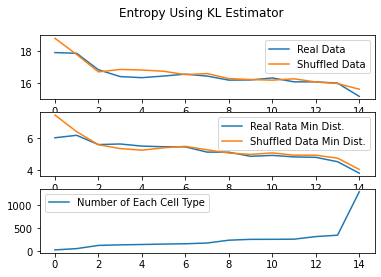

In [6]:
idxs=np.argsort(ctype_lenv) # sorting results based on the celltype lengths
hzpv=hzpv[idxs]
hzpv_sgt=hzpv_sgt[idxs]
hdzpv=hdzpv[idxs]
hdzpv_sgt=hdzpv_sgt[idxs]
ctype_lenv=ctype_lenv[idxs]
nnri_sgtv=nnri_sgtv[idxs]
nnriv=nnriv[idxs]

fig, axs =plt.subplots(3)
fig.suptitle('Entropy Using KL Estimator')
axs[0].plot(hzpv)
axs[0].plot(hzpv_sgt)
axs[0].legend(['Real Data', 'Shuffled Data'])

axs[1].plot(hdzpv)
axs[1].plot(hdzpv_sgt)
axs[1].legend(['Real Rata Min Dist.', 'Shuffled Data Min Dist.'])



axs[2].plot(ctype_lenv)
axs[2].legend(['Number of Each Cell Type'])



Plotting the results for NNRI

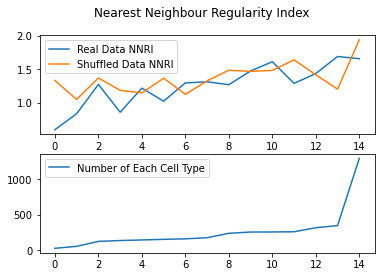

In [7]:
fig, axs =plt.subplots(2)
fig.suptitle('Nearest Neighbour Regularity Index')


axs[0].plot(nnriv)
axs[0].plot(nnri_sgtv)

axs[0].legend(['Real Data NNRI', 'Shuffled Data NNRI'])

axs[1].plot(ctype_lenv)
axs[1].legend(['Number of Each Cell Type'])

## Estimating KL Divergence


Reading all combinations of two selected cell types (X1=zp1, X2=zp2) to evaluate divg_vec=D(X1: X2). The KL divergence is also computed for the shuffled cell locations. First cell type (X1) is not shuffled, X2 is shuffled to compare how divergence changes.

X1 is named zp1 to reflect that it is a 2-dim vector of cartezian coordiante positions $z=[x, y]$.

In [8]:
k_wang=5
divg_vec=[]
divg_vec_sgt=[]
z1lenv=[]
z2lenv=[]

for ii in range(1, 16):
    zp1=zcoords[xy_Subtype==ii,:]
    dzp11=distance_matrix(zp1, zp1)
    rok=np.sort(dzp11, axis=1)[:,k_wang]

    zp1_sgt=zp1.copy()
    dzp11_sgt=distance_matrix(zp1_sgt, zp1_sgt)
    rok_sgt=np.sort(dzp11_sgt, axis=1)[:,k_wang]


    n=len(zp1)
    jjvec=np.arange(1, 16)
    jjvec=jjvec[jjvec!=ii]

    for jj in jjvec:
        np.random.shuffle(xy_Subtype_Shuffle)
        zp2=zcoords[xy_Subtype==jj,:]
        m=len(zp2)
        dzp12=distance_matrix(zp1, zp2)
        vik=np.sort(dzp12, axis=1)[:,k_wang-1]
        divg_vec=np.append(divg_vec, 2/n*np.sum(vik/rok)+m/(n-1)) # see Wang 2009

        zp2_sgt=zcoords[xy_Subtype_Shuffle==jj,:]
        dzp12_sgt=distance_matrix(zp1_sgt, zp2_sgt)
        vik_sgt=np.sort(dzp12_sgt, axis=1)[:,k_wang-1]
        
        divg_vec_sgt=np.append(divg_vec_sgt, 2/n*np.sum(vik_sgt/rok_sgt)+m/(n-1))
        z1lenv=np.append(z1lenv,n)
        z2lenv=np.append(z2lenv,m)



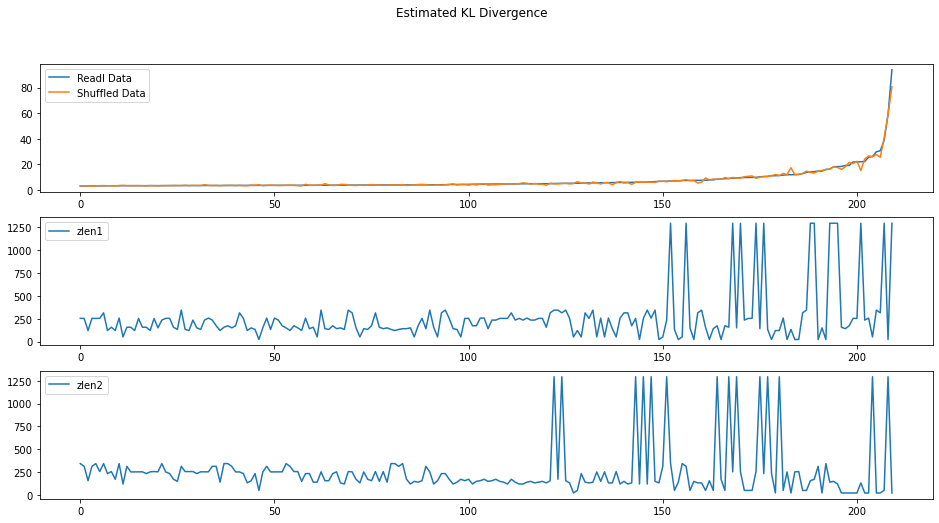

In [9]:
idx_sort=np.argsort(divg_vec) # sorting based on the divergence between real data subtypes

divg_vec=divg_vec[idx_sort]
z1lenv=z1lenv[idx_sort]
z2lenv=z2lenv[idx_sort]
divg_vec_sgt=divg_vec_sgt[idx_sort]

fig, axs=plt.subplots(3, figsize=[16,8])
fig.suptitle('Estimated KL Divergence')

axs[0].plot(divg_vec)
axs[0].plot(divg_vec_sgt)
axs[0].legend(['Readl Data', 'Shuffled Data'])

axs[1].plot(z1lenv)
axs[1].legend([ 'zlen1'])
axs[2].plot(z2lenv)
axs[2].legend([ 'zlen2'])


## Estimating Mutual Information


Reading all combinations of three selected cell types (X1=zp1, X2=zp2, X3=zp3) to evaluate I2gv=I(X1; X2), I3gv=I(X1; X3), and I23gv=I(X2, X3;X1). X2 , and X3 are paired with X1 based on the minimum distances. The mutulal informations are also computed for the shuffled cell locations. First cell type (X1) is not shuffled, X2, and X3 that provide information about X1 are shuffled.  

g index I2gv or I3gv is added to reflect that I have used the python codes developed by Gao in his github page to compute estimated ksg and revised ksg mutual informations. I've developed my own versions as well. 

In [10]:


I2gv=[]         # vector for real I(X1;X2)
I3gv=[]         # vector for real I(X1;X3)
I23gv=[]        # vector for real I(X2,X3;X1)

I2gv_shufl=[]  # vector for shuffled I(X1;X2)
I3gv_shufl=[]  # vector for shuffled I(X1;X3)
I23gv_shufl=[] # vector for shuffled I(X2,X3;X1)

zpos1_lenv=[] # vector for X1 lengths
zpos2_lenv=[] # vector for X2 lengths
zpos3_lenv=[] # vector for X3 lengths


for k_ksg in range(5, 6):
    for ii in range(1,16):

        len_ii=np.sum(xy_Subtype==ii)
        jjv=np.arange(1,16)
        jjv=jjv[jjv!=ii]

        for jj in jjv:
            len_jj=np.sum(xy_Subtype==jj)
            kkv=jjv.copy()
            kkv=kkv[kkv>jj]
            for kk in kkv:
                np.random.shuffle(xy_Subtype_Shuffle)
                len_kk=np.sum(xy_Subtype==kk)

                zp1=zcoords[xy_Subtype==ii]
                zp2=zcoords[xy_Subtype==jj]
                zp3=zcoords[xy_Subtype==kk]

                zp1_shufl=zcoords[xy_Subtype_Shuffle==ii]
                zp2_shufl=zcoords[xy_Subtype_Shuffle==jj]
                zp3_shufl=zcoords[xy_Subtype_Shuffle==kk]


                I2g, I3g, I23g=xy_mi(zp1, zp2, zp3, ki=k_ksg)
                I2g_shufl, I3g_shufl, I23g_shufl=xy_mi(zp1, zp2_shufl, zp3_shufl, ki=k_ksg)
                
                #len_scale=np.log(len(zp1)) 
                len_scale=1
                I2gv=np.append(I2gv, I2g/len_scale)
                I3gv=np.append(I3gv, I3g/len_scale)
                I23gv=np.append(I23gv, I23g/len_scale)

                I2gv_shufl=np.append(I2gv_shufl, I2g_shufl/len_scale)
                I3gv_shufl=np.append(I3gv_shufl, I3g_shufl/len_scale)
                I23gv_shufl=np.append(I23gv_shufl, I23g_shufl/len_scale)


                zpos1_lenv=np.append(zpos1_lenv,len(zp1))
                zpos2_lenv=np.append(zpos2_lenv,len(zp2))
                zpos3_lenv=np.append(zpos3_lenv,len(zp3))



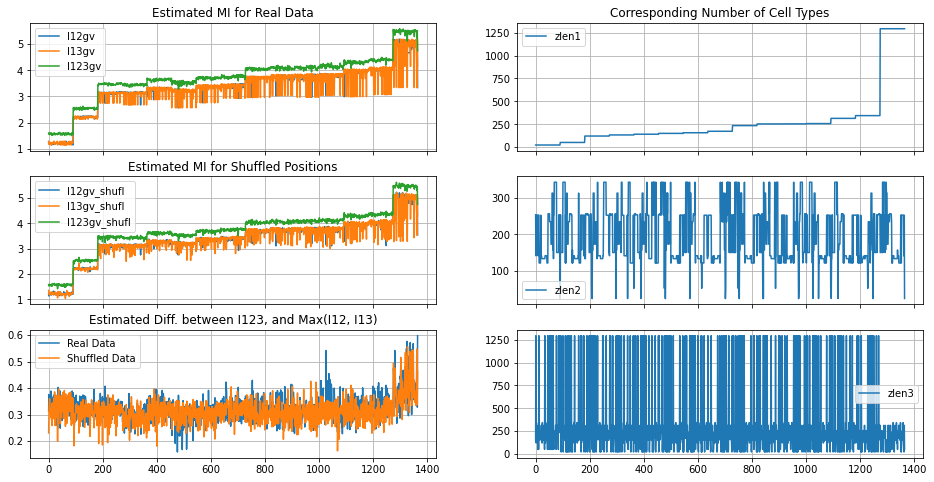

In [11]:
sort_idx=np.argsort(zpos1_lenv)  # sorting results based on the first celltype(Referece celltype) lengths
I2gv=I2gv[sort_idx]
I3gv=I3gv[sort_idx]
I23gv=I23gv[sort_idx]
I2gv_shufl=I2gv_shufl[sort_idx]
I3gv_shufl=I3gv_shufl[sort_idx]
I23gv_shufl=I23gv_shufl[sort_idx]

# difference between I23, and max(I2, I3), Synergistice information is less than Id.
Id=I23gv-np.maximum(I2gv, I3gv) 
Id_shufl=I23gv_shufl-np.maximum(I2gv_shufl, I3gv_shufl)

zpos1_lenv=zpos1_lenv[sort_idx]
zpos2_lenv=zpos2_lenv[sort_idx]
zpos3_lenv=zpos3_lenv[sort_idx]



fig, axs = plt.subplots(3,2, figsize=[16,8],sharex=True)

axs[0,0].plot(I2gv)
axs[0,0].plot(I3gv)
axs[0,0].plot(I23gv)
axs[0,0].grid()
axs[0,0].legend(['I12gv', 'I13gv', 'I123gv'])
axs[0,0].set_title('Estimated MI for Real Data')

axs[1,0].plot(I2gv_shufl)
axs[1,0].plot(I3gv_shufl)
axs[1,0].plot(I23gv_shufl)
axs[1,0].grid()
axs[1,0].legend(['I12gv_shufl', 'I13gv_shufl', 'I123gv_shufl'])
axs[1,0].set_title('Estimated MI for Shuffled Positions')


axs[2,0].plot(Id)
axs[2,0].plot(Id_shufl)

axs[2,0].grid()
axs[2,0].set_title('Estimated Diff. between I123, and Max(I12, I13)')
axs[2,0].legend(['Real Data', 'Shuffled Data'])




axs[0,1].plot(zpos1_lenv)

axs[0,1].grid()
axs[0,1].legend(['zlen1'])
axs[0,1].set_title('Corresponding Number of Cell Types')

axs[1,1].plot(zpos2_lenv)
axs[1,1].grid()
axs[1,1].legend([ 'zlen2'])

axs[2,1].plot(zpos3_lenv)
axs[2,1].grid()
axs[2,1].legend([ 'zlen3'])



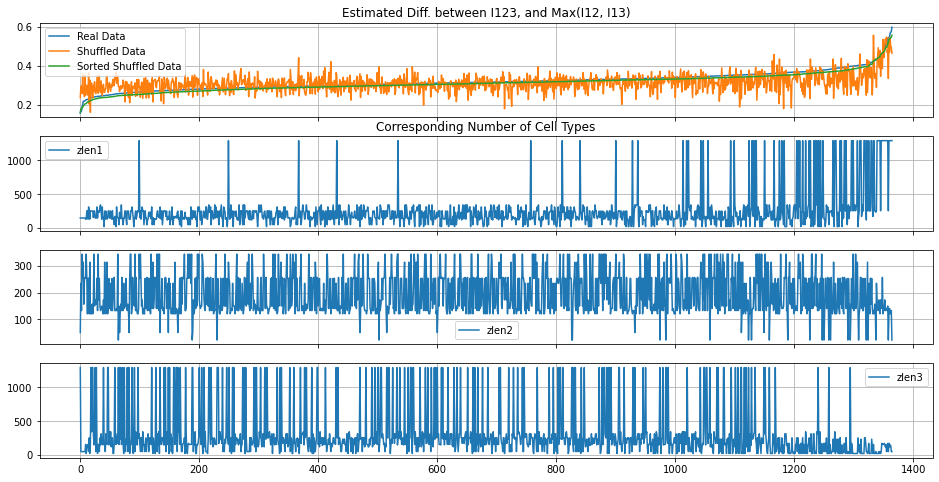

In [12]:
sort_idx=np.argsort(Id) # sorting results based on Id. 
I2gv=I2gv[sort_idx]
I3gv=I3gv[sort_idx]
I23gv=I23gv[sort_idx]

I2gv_shufl=I2gv_shufl[sort_idx]
I3gv_shufl=I3gv_shufl[sort_idx]
I23gv_shufl=I23gv_shufl[sort_idx]

Id=Id[sort_idx]
Id_shufl=Id_shufl[sort_idx]


zpos1_lenv=zpos1_lenv[sort_idx]
zpos2_lenv=zpos2_lenv[sort_idx]
zpos3_lenv=zpos3_lenv[sort_idx]


fig, axs = plt.subplots(4, figsize=[16,8], sharex=True)

axs[0].plot(Id)
axs[0].plot(Id_shufl)
axs[0].plot(np.sort(Id_shufl))

axs[0].grid()
axs[0].set_title('Estimated Diff. between I123, and Max(I12, I13)')
axs[0].legend(['Real Data', 'Shuffled Data', 'Sorted Shuffled Data'])



axs[1].plot(zpos1_lenv)
axs[1].grid()

axs[1].legend(['zlen1'])
axs[1].set_title('Corresponding Number of Cell Types')

axs[2].plot(zpos2_lenv)
axs[2].grid()

axs[2].legend(['zlen2'])

axs[3].plot(zpos3_lenv)
axs[3].grid()

axs[3].legend(['zlen3'])

